In [ ]:
# clone the dataset repository 
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
# important library to virtualize the loss surface
!pip install mlvtk

In [ ]:
# import importante libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from mlvtk.base import Vmodel
from tensorflow.keras.models import load_model
import random
import pickle
import pandas as pd
import cv2

In [ ]:
# to generate random numbers with a specific seed
np.random.seed(0)

# load train, validation, and Test data from the traffic signs data set
# this data set is cloned from bitbucket https://bitbucket.org/jadslim/german-traffic-signs
# not that the files are pickle files, which need a special way to read
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# every set from above has data and labels ==> (x , y)
# the datatype of the previous sets are a dictionary, so we can access 
# lables and data using key=features, and key=labels
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [ ]:
# to show dimensions of the datasets
# you will not that the pictures are 32*32 
# with depth 3, which means colored pictures 
# already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:
# some test to make sure of dimensions compatibility 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

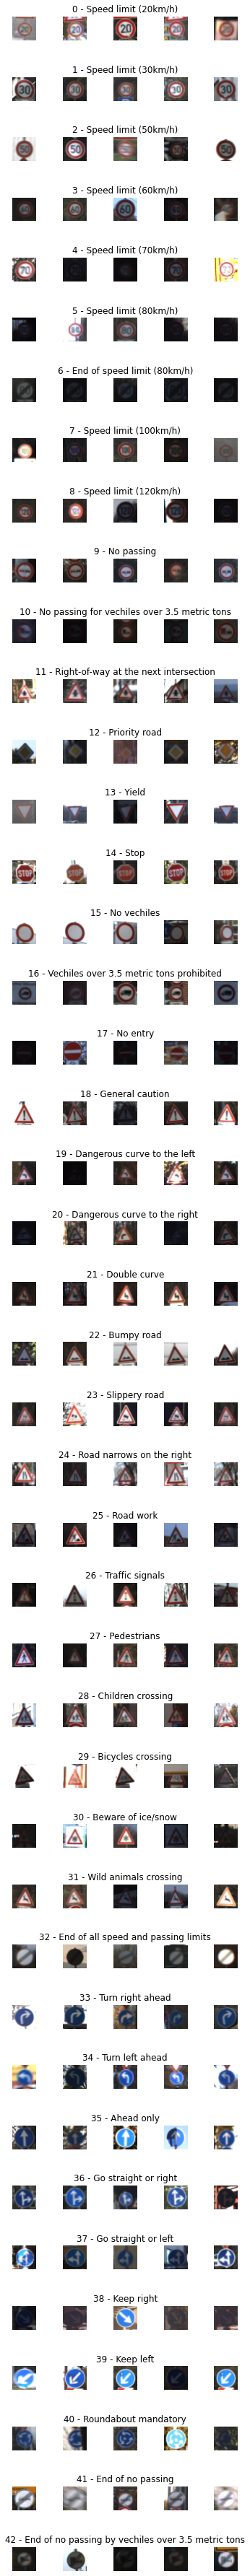

In [ ]:
# read the CSV file using pandas lib, this file contains the 43 classes
# of difrents trafic signs
data = pd.read_csv('german-traffic-signs/signnames.csv')

# some code to show random pics from the 43 classes
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))



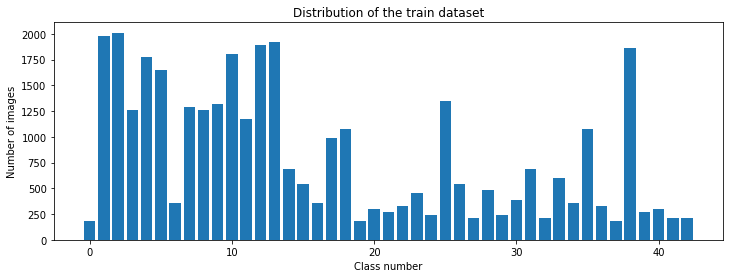

In [ ]:
# to show the distribution of the training dataset
# how many images are in each class
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


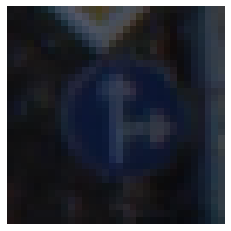

In [ ]:
# show random image from the training set
# with its details and class
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


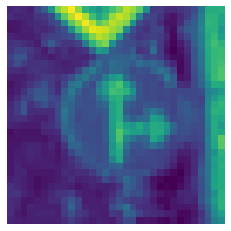

In [ ]:
# preproccessing the images before training the model
# important steps must be applied on the image before start training

# function to converting the image into gray scale
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# show the image after converting ( can be deleted later)
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


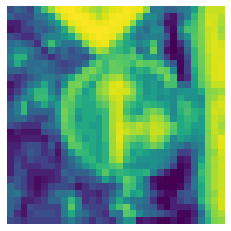

In [ ]:
# equalize the histogram, very important step to increase 
# the contrast of the image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

# show th image after equalization
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
# a function to combine the two previous transformations
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img



In [ ]:
# applying the preprocess function on the all datasets one by one
# using the map function
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


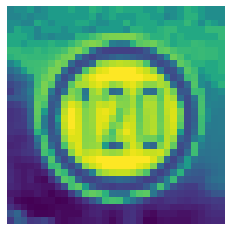

In [ ]:
# showing a random image from the training set after processing
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
# adding a depth layer of 1, to be suitable with the CNN model
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


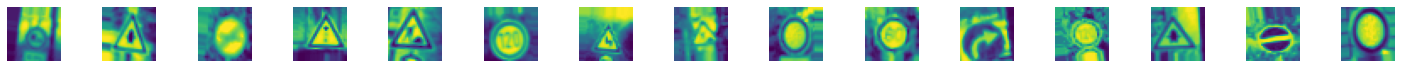

In [ ]:
# this is a very important step, we want to manipulate the training images 
# to get more accuracy at the final model, and to generalise results for other 
# new images, this process called  Data Augmentation

# first we build object from the class ImageDataGenerator with manpulating parameters
# width_shift_range= 0.1 means 10% width shift
# height_shift_range= 0.1 means 10% hight shift
# zoom_range=0.2 means 20% outzoom and 80% inzoom
# shear_range = 0.1  Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#  rotation_range= 10 degree
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

# apply it on the train data
datagen.fit(X_train)

# for X_batch, y_batch in and define the batch size
batches = datagen.flow(X_train, y_train, batch_size = 50)
X_batch, y_batch = next(batches)

# to show one batch new generated images 
fig, axs = plt.subplots(1, 50, figsize=(20, 5))
fig.tight_layout()

for i in range(50):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

#dimensions of the new images
print(X_batch.shape)



In [ ]:
# using the to_categorical function to hot encode the output classes
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# create CNN model
# function to build a CNN model
def modified_model():
  # building a multilayer Neural network
  model = Sequential()

  # adding the first layer which is a convolutional layer with input shape 
  # is an image 32*32*1 , and this layer contains 60 filters with the size of
  # 5*5 and an activation function is relu, which convert the negative 
  # values after convolution process to zero
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))

  # another convolutional layer to increase accuracy with the same parameters
  model.add(Conv2D(60, (5, 5), activation='relu'))

  # adding the first pooling layer to decrease the size of the images
  # with size 2,2 and that's mean that it will be decreased by half
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # adding 2 convolutional layer with 30 filters with size of 3*3
  # all of this to increase accuracy
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))

  # adding pooling layer to decrease the size to half
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # converting the output of the previous layer to a series of data
  # to make it suited to the fully connected layer
  model.add(Flatten())

  # adding a normal neurons layers contain 500 nodes
  model.add(Dense(500, activation='relu'))

  # to avoid overfitting we use a dropout layer, which cut to half 
  # the number of neurons every iteration when training
  # also the importance of this layer is to generalise 
  # the model for new data. 0.5 means half of the nodes will be dropped
  model.add(Dropout(0.5))

  # finally, output layer which contain 43 classes 
  model.add(Dense(43, activation='softmax'))

  # Wrap with Vmodel to plot the loss surface
  model = Vmodel(model)
 
  # defining the Adam optimizer with 0.001 learning rate and focusing on accuracy as a metric
  # with Categorical cross entropy loss function
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# calling the function to build the CNN model
model = modified_model()

# to show information of the model
print(model.summary())
model.get_config()
model.get_weights()
model.layers



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [ ]:



# start the training process with the real and augmented data
# epochs=10 number of iterations over the whole data
# batch_size = 2000, how many items will be processed at a time
# shuffle = 1, to shuffle data when iteration
# notice: Use --steps argument while train.
# Steps should be smaller than or equal to the length of your dataset/batch size.
# For example:
# if your dataset has 1000 images and batch size is 1 --steps 1000
# if  your dataset has 1000 images and batch size is 2 --steps 500
history = model.fit( datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=650,
                              epochs=10,
                              validation_data=(X_val, y_val),
                              shuffle = 1)

Please enter new save folder path new3
Epoch 1/10
650/650 [==============================] - 20s 30ms/step - loss: 0.9188 - accuracy: 0.7181 - val_loss: 0.2447 - val_accuracy: 0.9268
Epoch 2/10
650/650 [==============================] - 19s 29ms/step - loss: 0.4694 - accuracy: 0.8540 - val_loss: 0.1452 - val_accuracy: 0.9580
Epoch 3/10
650/650 [==============================] - 19s 29ms/step - loss: 0.3244 - accuracy: 0.8979 - val_loss: 0.1270 - val_accuracy: 0.9592
Epoch 4/10
650/650 [==============================] - 19s 29ms/step - loss: 0.2493 - accuracy: 0.9223 - val_loss: 0.0558 - val_accuracy: 0.9828
Epoch 5/10
650/650 [==============================] - 19s 29ms/step - loss: 0.2184 - accuracy: 0.9330 - val_loss: 0.0412 - val_accuracy: 0.9887
Epoch 6/10
650/650 [==============================] - 19s 30ms/step - loss: 0.1834 - accuracy: 0.9431 - val_loss: 0.0454 - val_accuracy: 0.9862
Epoch 7/10
650/650 [==============================] - 19s 29ms/step - loss: 0.1673 - accuracy: 0.

In [ ]:

# Calling model.surface_plot() returns a plotly.graph_objs.Figure
fig = model.surface_plot()

# saving the plot in HTML file
fig.write_html("surface_plot.html")

# or display the plot in jupyter notebook or other compatible tool.
fig.show()

Text(0.5, 0, 'epoch')

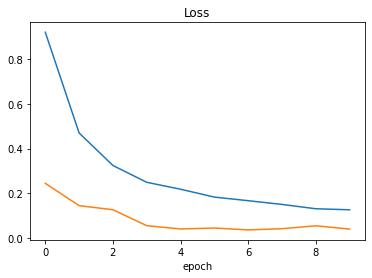

In [ ]:
#  to show losses plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

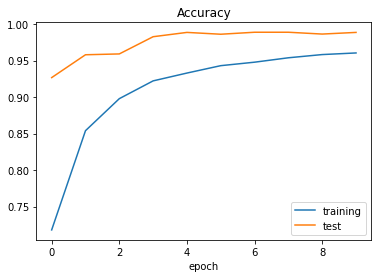

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
# By Ashraf Kasem
# Email: ashraf.kasem.94.0@gmail.com

# New Section